# mixture density networks 


- About density estimation: http://scikit-learn.org/stable/modules/density.html


- http://tullo.ch/articles/speeding-up-isotonic-regression/

We want to model the conditional distribution as a mixture of Gaussians, where each Gaussian component parameters are dependent on the input, that is 


\begin{equation}
P(y^m \mid x^m) = \sum_{k=1}^K \pi_k(x^m) \mathcal{N} \left( y^m \mid \mu_k(x^m) , \sigma_k^2(x^m) \right)
\end{equation}


In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

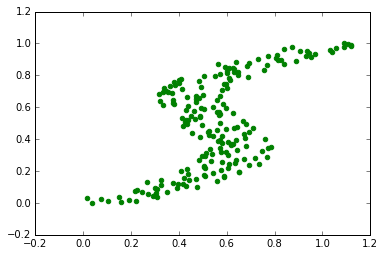

In [3]:
# generate some 1D regression data (reproducing Bishop book data, page 273). 
# Note that the P(y|x) is not a nice distribution.
# E.g. it has three modes for x ~= 0.5
N = 200
X = np.linspace(0,1,N)
Y = X + 0.3 * np.sin(2*3.1415926*X) + np.random.uniform(-0.1, 0.2, N)
X,Y = Y,X
plt.scatter(X,Y,color='g')

## About the model

Now we will present a mixture density network (MDN) with a single hidden layer. This model can be generalized using as many hidden layers as we want defined just like in a regular multilayer perceptron. The main difference between an standard MLP and a MDN is the output layer which will be specified in the following:

#### Weights

Let us assume we are training a MDN with $K$ Gaussian components and the objective is to build a density $P(t \mid x)$ where the target $t$ is a 1D variable (that is we are studying a 1D regression problem).

- First layer weights W1 defines a mapping from the input to the hidden layer.

- Second layer weights are composed by:

    - A weight matrix for the mixing coefficients $\pi_k$:  ```W_pi``` of shape ```(hidden_size, K)```
        
    - A weight matrix for the for the means of the Gaussian components $\mu_k$: ```W_mean``` of shape ```(hidden_size, K)```
    
    -  A weight matrix for the variances of the Gaussian components $\sigma_k^2$:  ```W_variance``` of shape ```(hidden_size, K)```

- Second layer biases are composed by:

    - A bias for the hidden layer: shape (hidden_size,1)
    
    - A bias for the mixing coefficients: shape (K,1)
    
    - A bias for the means of the Gaussian components: shape (K,1)
    
    - A bias for the variances of the Gaussian components: shape (K,1)


In [4]:
#from sklearn import utils, base
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_array, check_X_y, column_or_1d
from sklearn.utils.extmath import safe_sparse_dot

In [5]:
help(safe_sparse_dot)

Help on function safe_sparse_dot in module sklearn.utils.extmath:

safe_sparse_dot(a, b, dense_output=False)
    Dot product that handle the sparse matrix case correctly
    
    Uses BLAS GEMM as replacement for numpy.dot where possible
    to avoid unnecessary copies.



In [6]:
np.random.randn(10,)

array([ 0.92111535, -0.07208919,  0.46236699,  0.24376157,  0.83892899,
       -1.48736362,  0.36939184,  0.25705309,  0.71534711, -0.20409744])

In [7]:
np.random.randn(5,1)

array([[-0.55907185],
       [-0.2859028 ],
       [-1.03135695],
       [ 1.32765524],
       [ 0.97546939]])

In [8]:
def softmax(x):
    # softmaxes the columns of x
    #z = x - np.max(x, axis=0, keepdims=True) # for safety
    e = np.exp(x)
    en = e / np.sum(e, axis=0, keepdims=True)
    return en


In [9]:
import numpy  as np

In [24]:
class MDNRegressor(BaseEstimator, RegressorMixin):

    """
    Mixture density network regression. This version assumes
        - A single layer of hidden units.
        - Target variable to be 1-dimensional
    
    hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 
       The ith element represents the number of neurons in the ith
       hidden layer.
       
    activation: {'tanh'}
    
    shuffle : bool, optional, default True
        Whether to shuffle samples in each iteration. 
        
    """
    
    def __init__(self,
                 hidden_layer_size,
                 n_components = 5,
                 activation="tanh",
                 batch_size= "auto",
                 shuffle=True):
        
        self.hidden_layer_size = hidden_layer_size
        self.n_components = n_components
        self.activation = activation
        self.batch_size = batch_size
        self.shuffle = shuffle
            
    def _initialize_in_fit(self, 
                           n_features,
                           n_hidden, 
                           n_outputs, 
                           n_components):
        """
        Initialize the model weights and biases
        """
        scaling_factor = 0.1
        
        # n_outputs = y.shape[1]
        self.n_outputs_ = n_outputs
        self.loss_per_epoch = []
        
        # Initialize coefficient and intercept layers
        self.coefs_ = {'W_1': np.random.randn(n_features, n_hidden) * scaling_factor,
                       'W_variance': np.random.randn(n_hidden, n_components) * scaling_factor,
                       'W_mean': np.random.randn(n_hidden, n_components) * scaling_factor,
                       'W_mix_coeff':np.random.randn(n_hidden, n_components) * scaling_factor}
        
        self.intercepts_ = {'b_1':  np.zeros(n_hidden, ),
                            'b_variance': np.zeros(n_components, ),
                            'b_mean': np.zeros(n_components, ),
                            'b_mix_coeff':  np.zeros(n_components, )}
            
    def predict_statistics(self, X):
        """
        For each of the K components predicts
            - the expected value (mean of the Gaussian) for a given x
            - the variance of the prediction (variance of the Gaussian)
            - the weight or coefficient of the component
        """
        # compute hidden activation
        
        
    def _validate_hyperparameters(self):
        """
        Ensures hyperparameters are set correctly
        """
        if not isinstance(self.shuffle, bool):
            raise ValueError("shuffle must be either True or False, got %s." %
                             self.shuffle)       
    
    def _validate_input(self, X, y, incremental):
        
        if y.ndim == 2 and y.shape[1] == 1:
            y = column_or_1d(y, warn=True)
        return X,y
            
    def _forward_pass(self, X):
        activations = [X]
        

    def _compute_loss(self, X, y):
        """
        Returns the probability
        """
             
        # Ensure y is 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))            

        ### Forward pass ###
        act_h1 = np.tanh( np.dot(X, self.coefs_['W_1']) + self.intercepts_['b_1']  )
        
        act_means = np.dot(act_h1, self.coefs_['W_mean']) + self.intercepts_['b_mean']
        act_variances = np.exp(np.dot(act_h1,self.coefs_['W_variance']) + self.intercepts_['b_variance'])
        act_mixing_coeff = softmax(np.dot(act_h1,self.coefs_['W_mix_coeff']) + self.intercepts_['b_mix_coeff'])
        
        ###
        ### Compute Loss (- mean log-likelihood)
        ###
        n_samples, n_components = act_means.shape
        
        # prob_per_sample has shape (n_components, n_samples)
        prob_per_sample = np.exp(-((y - act_means)**2)/(2*act_variances**2))/(act_variances*np.sqrt(2*np.pi))

        pin = act_mixing_coeff * prob_per_sample
        # logprob has shape (1,n_samples)
        logprob = -np.log(np.sum(pin, axis=0, keepdims=True))
        loss = np.sum(logprob)/n_samples
        import pdb;pdb.set_trace()
        
        stats = {}
        stats["lp"] = logprob 
        return stats


    def _compute_grads(self, X, y):
        
        ### Forward pass ###
        act_h1 = np.tanh( np.dot(X, self.coefs_['W_1']) + self.intercepts_['b_1']  )
        
        act_means = np.dot(act_h1, self.coefs_['W_mean']) + self.intercepts_['b_mean']
        act_variances = np.exp(np.dot(act_h1,self.coefs_['W_variance']) + self.intercepts_['b_variance'])
        act_mixing_coeff = softmax(np.dot(act_h1,self.coefs_['W_mix_coeff']) + self.intercepts_['b_mix_coeff'])
        
        ###
        ### Compute Loss (- mean log-likelihood)
        ###
        n_samples, n_components = act_means.shape
        
        # prob_per_sample has shape (n_components, n_samples)
        prob_per_sample = np.exp(-((y - act_means)**2)/(2*act_variances**2))/(act_variances*np.sqrt(2*np.pi))
        pin = act_mixing_coeff * prob_per_sample
        
        # logprob has shape (1,n_samples)
        logprob = -np.log(np.sum(pin, axis=0, keepdims=True))
        loss = np.sum(logprob)/n_samples

        ###
        ### Gradients 
        ###
        
        ### Gradients of the loss with respect to the parameters of the output layer
        gammas = pin / np.sum(pin, axis=0, keepdims = True)
        dmu = gammas * ((act_means - y)/act_variances**2) / n_samples
        dlogsig = gammas * (1.0 - (y - act_means)**2/(act_variances**2)) / n_samples
        dpiu = (act_mixing_coeff - gammas) / n_samples
    
        grads = {}
        grads['W_mean'] = np.dot(dmu.T, act_h1).T
        grads['W_variance'] = np.dot(dlogsig.T, act_h1).T
        grads['W_mix_coeff'] = np.dot(dpiu.T, act_h1).T

        grads['b_mean'] = np.sum(dmu, axis=0)
        grads['b_variance'] = np.sum(dlogsig, axis=0)
        grads['b_mix_coeff'] = np.sum(dpiu, axis=0)

        ### Gradients of the loss with respect to the parameters of the first layer
        dh = np.dot(self.coefs_['W_mean'], dmu.T) + \
             np.dot(self.coefs_['W_variance'], dlogsig.T) +\
             np.dot(self.coefs_['W_mix_coeff'], dpiu.T)

        #import pdb; pdb.set_trace()
        
        dh = (1.0 - act_h1**2)*dh.T
        grads['W_1'] = np.sum(dh, axis=0)       
        grads['b_1'] = np.dot(dh.T, X).flatten()
        self.loss_per_epoch.append(loss)
        
        return grads
        
        
    def _fit(self, X, y, n_epochs = 20000, n_epochs_to_print=1000):
        """
        Train the model
        """
        ###########
        # Prepare #
        ###########
        
        # Do stuff here
        hidden_layer_size = self.hidden_layer_size
        
        # Validate input parameters.
        self._validate_hyperparameters()
        if np.any(np.array(hidden_layer_size) <= 0):
            raise ValueError("hidden_layer_sizes must be > 0, got %s." %
                             hidden_layer_size)
            
        # Validate input
        X, y = self._validate_input(X, y, incremental=True)
        
        # Ensure y is 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))            

        self.n_outputs_ = y.shape[1]
        n_features = X.shape[1]
        
        # Initialize model
        self._initialize_in_fit(n_features,
                                hidden_layer_size,
                                self.n_outputs_,
                                self.n_components)
        
        ###########
        # Train   #
        ###########
        learning_rate = 0.01
        
        ### Initialize adagrad
        mem = {}
        for k in self.coefs_.keys(): 
            mem[k] = np.zeros_like(self.coefs_[k]) 
        for k in self.intercepts_.keys(): 
            mem[k] = np.zeros_like(self.intercepts_[k])
        
        
        #nb = n_samples #full batch
        #xbatch = np.reshape(X[:nb], (1,nb))
        #ybatch = np.reshape(Y[:nb], (1,nb))
        
        for epoch in range(n_epochs):
            
            grads = self._compute_grads(X, y)
            if epoch % n_epochs_to_print == 0:
                print ("epoch: ", epoch, "loss: ", self.loss_per_epoch[-1])

            for k,v in grads.items():
                mem[k] += grads[k]**2
                
                if k in self.coefs_:
                    self.coefs_[k] += -learning_rate * grads[k] / np.sqrt(mem[k] + 1e-8)
                else:
                    self.intercepts_[k] += -learning_rate * grads[k] / np.sqrt(mem[k] + 1e-8)                
        
            
    def fit(self, X, y):
        return self._fit(X, y)

In [25]:
X = X.reshape(-1,1)
X.shape, Y.shape

((200, 1), (200,))

In [26]:
mdn =  MDNRegressor(hidden_layer_size=10, n_components=3)

In [27]:
mdn.fit(X,Y)

epoch:  0 loss:  0.0160993764265
epoch:  1000 loss:  -0.0228657552289
epoch:  2000 loss:  -0.0254963668592
epoch:  3000 loss:  -0.0327408437624
epoch:  4000 loss:  -0.0310569039853
epoch:  5000 loss:  -0.0330759457432
epoch:  6000 loss:  -0.03539244037
epoch:  7000 loss:  -0.0380374859807
epoch:  8000 loss:  -0.0383454857401
epoch:  9000 loss:  -0.0350753191918
epoch:  10000 loss:  -0.0400612147553
epoch:  11000 loss:  -0.0450724908892
epoch:  12000 loss:  -0.0368639968515
epoch:  13000 loss:  -0.044084565098
epoch:  14000 loss:  -0.0411556493412
epoch:  15000 loss:  -0.0349220317919
epoch:  16000 loss:  -0.0349891216175
epoch:  17000 loss:  -0.0413660976969
epoch:  18000 loss:  -0.0256860038159
epoch:  19000 loss:  -0.0261618928669


In [28]:
X.shape, Y.shape

((200, 1), (200,))

In [29]:
mdn._compute_loss(X[0:8],Y[0:8])

/home/david/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:112: RuntimeWarning: divide by zero encountered in log


> <ipython-input-24-a35d80926ce1>(116)_compute_loss()
-> stats = {}
(Pdb) loss
inf
(Pdb) logprob 
array([[ inf,  inf,  inf]])
(Pdb) pin =
*** SyntaxError: invalid syntax
(Pdb) pin 
array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])
(Pdb) pin.shape
(8, 3)
(Pdb) act_mixing_coeff.shape
(8, 3)
(Pdb) act_mixing_coeff
array([[ 0.07150622,  0.0677239 ,  0.07628362],
       [ 0.14521919,  0.14607263,  0.14399567],
       [ 0.10576605,  0.10356144,  0.10836633],
       [ 0.21052553,  0.21854085,  0.20088492],
       [ 0.17519287,  0.17905113,  0.17037871],
       [ 0.08914909,  0.08603195,  0.09296647],
       [ 0.06307593,  0.05910529,  0.06816584],
       [ 0.13956511,  0.13991282,  0.13895844]])
(Pdb) prob_per_sample
array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,

BdbQuit: 

In [71]:


act_h1 = np.tanh( np.dot(X, mdn.coefs_['W_1']) + mdn.intercepts_['b_1']  )

act_means = np.dot(act_h1, mdn.coefs_['W_mean']) + mdn.intercepts_['b_mean']
act_variances = np.exp(np.dot(act_h1,mdn.coefs_['W_variance']) + mdn.intercepts_['b_variance'])
act_mixing_coeff = softmax(np.dot(act_h1,mdn.coefs_['W_mix_coeff']) + mdn.intercepts_['b_mix_coeff'])




In [72]:

###
### Compute Loss (- mean log-likelihood)
###
n_samples, n_components = act_means.shape
#import pdb;pdb.set_trace()



In [73]:
Y.shape

(200,)

In [65]:
act_means.shape

(200, 3)

In [59]:
np.exp(-((Y - act_means)**2))

ValueError: operands could not be broadcast together with shapes (200,) (200,3) 

In [54]:
p.exp(-((Y - act_means)**2)/(2*act_variances**2))/(act_variances*np.sqrt(2*np.pi))


NameError: name 'p' is not defined

In [ ]:


# prob_per_sample has shape (n_components, n_samples)
prob_per_sample = np.exp(-((y - act_means)**2)/(2*act_variances**2))/(act_variances*np.sqrt(2*np.pi))
pin = act_mixing_coeff * prob_per_sample
# logprob has shape (1,n_samples)
logprob = -np.log(np.sum(pin, axis=0, keepdims=True))
loss = np.sum(logprob)/n_samples

In [78]:
# utility function for creating contour plot of the predictions
def drawContour(model):
    n = 50
    xx = np.linspace(0,1,n)
    yy = np.linspace(0,1,n)
    xm, ym = np.meshgrid(xx, yy)
    
    X = xm.reshape(xm.size,1)
    y =  ym.reshape(ym.size)
    
    print("X :", X.shape)
    print("y: ", y.shape)
    print(X)
    _, _, stats = model._compute_loss(X, y)
    logps = stats["lp"]
    plt.figure(figsize=(10,10))
    plt.scatter(X,Y,color='g')
    lp = stats['lp']
    plt.contour(xm, ym, np.reshape(logps, (n, n)), levels=np.linspace(lp.min(), lp.max(), 50))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('3-component Gaussian Mixture Model for P(y|x)')

In [76]:
drawContour(model=mdn)

X : (2500, 1)
y:  (2500,)
[[ 0.        ]
 [ 0.02040816]
 [ 0.04081633]
 ..., 
 [ 0.95918367]
 [ 0.97959184]
 [ 1.        ]]


ValueError: operands could not be broadcast together with shapes (2500,) (2500,3) 

In [36]:
X.shape

(200, 1)

In [19]:
X.shape, Y.shape

((200, 1), (200,))

In [20]:
X = X.reshape(-1,1)

In [42]:
X.shape, Y.shape

((200, 1), (200,))

In [43]:
X[0:3], Y[0:3]

(array([[-0.06288342],
        [-0.02550665],
        [ 0.02676715]]), array([ 0.        ,  0.00502513,  0.01005025]))

In [44]:
mdn._initialize_in_fit(n_features=1, n_hidden=4, n_outputs=1, n_components=5)

In [45]:
Xbatch = X[0:3]
# activation at the hidden layer for each of the element s in the minibatch
act_h1 = np.dot(Xbatch, mdn.coefs_["W_1"]) + mdn.intercepts_["b_1"]

In [46]:
np.dot(act_h1,mdn.coefs_['W_mean'])

array([[  1.72225560e-03,  -2.82623485e-04,  -1.50002264e-04,
          9.53050363e-04,  -4.09432060e-04],
       [  6.98577901e-04,  -1.14637177e-04,  -6.08436207e-05,
          3.86574398e-04,  -1.66073020e-04],
       [ -7.33100586e-04,   1.20302377e-04,   6.38504223e-05,
         -4.05678332e-04,   1.74280102e-04]])

In [47]:
mdn.intercepts_['b_mean'].shape

(5,)

In [48]:
act_means = np.dot(act_h1,mdn.coefs_['W_mean']) + mdn.intercepts_['b_mean']

In [49]:
#mdn.fit(X,Y)

In [50]:
n_hidden = 10
a = {"b_1":  np.zeros(n_hidden, 0)}

TypeError: data type not understood

In [39]:
a = {"b_1":  np.zeros(100, 0)}

TypeError: data type not understood

In [40]:
np.zeros(100, 0)

TypeError: data type not understood

In [43]:
np.zeros(100,)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])